In [1]:
#Import all packages
import gurobipy as gp
from gurobipy import GRB
from gerrychain import Graph
import networkx as nx
import geopandas as gpd
import math

In [2]:
# Set filename and filepath equal to the name and path of the data used
filename = 'WV_county.json'
filepath = 'C:\\Users\\ethan\\Documents\\'

# Create a new Graph object G from the file
G = Graph.from_json(filepath + filename)

In [3]:
#Set each node in G to be equal to the population of their respective county

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [4]:
#Print each node, the name of the county it represents, and their 2020 population

for node in G.nodes:
    name = G.nodes[node]['NAME20']
    population = G.nodes[node]['TOTPOP']
    print("Node",node,"represents",name,"County with 2020 population of",population)

Node 0 represents Wyoming County with 2020 population of 21382
Node 1 represents Braxton County with 2020 population of 12447
Node 2 represents Roane County with 2020 population of 14028
Node 3 represents Grant County with 2020 population of 10976
Node 4 represents Monroe County with 2020 population of 12376
Node 5 represents Doddridge County with 2020 population of 7808
Node 6 represents Wirt County with 2020 population of 5194
Node 7 represents Tyler County with 2020 population of 8313
Node 8 represents Greenbrier County with 2020 population of 32977
Node 9 represents Ritchie County with 2020 population of 8444
Node 10 represents Randolph County with 2020 population of 27932
Node 11 represents Marion County with 2020 population of 56205
Node 12 represents Pendleton County with 2020 population of 6143
Node 13 represents Summers County with 2020 population of 11959
Node 14 represents Berkeley County with 2020 population of 122076
Node 15 represents Upshur County with 2020 population of

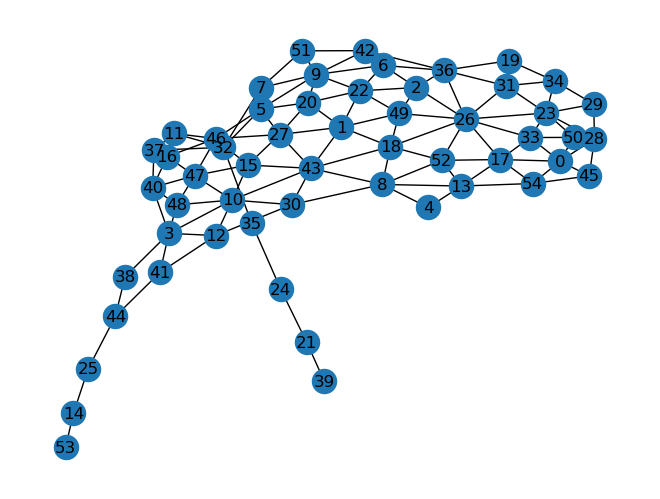

In [5]:
# Draw the graph of nodes

nx.draw(G, with_labels=True)

In [6]:
# Set the ceiling and floor of the model equal to the maximum deviation/2 * the average population

deviation = 0.01

k = 2    # Number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("L =",L,"and U =",U,"and k =",k)

L = 892374 and U = 901342 and k = 2


In [7]:
# Create a new model

m = gp.Model()

# Create new variables

x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # Counties
y = m.addVars(G.edges, vtype=GRB.BINARY)  # Edges

Restricted license - for non-production use only - expires 2025-11-24


In [8]:
# Set objective to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [9]:
# Each county i is assigned to a district j

m.addConstrs(gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# Each district j has a population at least L and at most U

m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k))
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k))

# An edge is cut if u is assigned to district j but v is not.

m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))
m.update()

In [10]:
# Add root variables: r[i,j] equals 1 if node i is the root of district j

r = m.addVars( G.nodes, k, vtype=GRB.BINARY)
DG = nx.DiGraph(G)
f = m.addVars(DG.edges)

In [11]:
M = G.number_of_nodes() - k + 1

# Each district should have one root

m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root

m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) )

# If not a root, consume some flow
# If a root, only send out (so much) flow

m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# Do not send flow across cut edges

m.addConstrs( f[i,j] + f[j,i] <= M * (1-y[i,j] )for i,j in G.edges)

m.update()

In [12]:
# solve IP model

m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 601 rows, 595 columns and 2395 nonzeros
Model fingerprint: 0x693dd969
Variable types: 250 continuous, 345 integer (345 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+05]
Presolve removed 57 rows and 55 columns
Presolve time: 0.02s
Presolved: 544 rows, 540 columns, 2175 nonzeros
Variable types: 250 continuous, 290 integer (290 binary)

Root relaxation: objective 0.000000e+00, 205 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000

In [13]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their population

districts = [[i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [[G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k)]

# print

for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 12.0
District 0 has population 899234 and contains counties ['Wyoming', 'Roane', 'Monroe', 'Wirt', 'Greenbrier', 'Summers', 'Raleigh', 'Mason', 'Lincoln', 'Kanawha', 'Mingo', 'Wayne', 'Putnam', 'Boone', 'Cabell', 'Jackson', 'Wood', 'McDowell', 'Logan', 'Fayette', 'Mercer']

District 1 has population 894482 and contains counties ['Braxton', 'Grant', 'Doddridge', 'Tyler', 'Ritchie', 'Randolph', 'Marion', 'Pendleton', 'Berkeley', 'Upshur', 'Taylor', 'Nicholas', 'Gilmer', 'Brooke', 'Calhoun', 'Ohio', 'Morgan', 'Lewis', 'Pocahontas', 'Wetzel', 'Marshall', 'Monongalia', 'Mineral', 'Hancock', 'Preston', 'Hardy', 'Webster', 'Hampshire', 'Harrison', 'Barbour', 'Tucker', 'Clay', 'Pleasants', 'Jefferson']



In [14]:
filename = 'WV_county.shp'
filepath = 'C:\\Users\\ethan\\Documents\\'

# Read geopandas dataframe from file

df = gpd.read_file( filepath + filename )

C:\Users\ethan\anaconda4\envs\gpd\lib\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


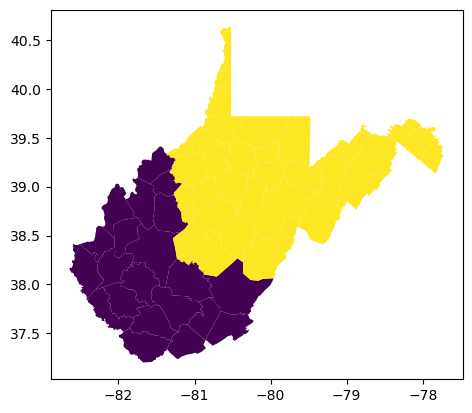

In [15]:
# Which district is each county assigned to?

assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it

node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# Pick a position u in the dataframe

for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
   
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given the same district # that county i has in 'labeling'
  
    assignment[u] = labeling[i]
    
# Add the assignments to a column of our dataframe and map it.

df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()